In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos, numbered_symbols
import numpy as np
import rebound
from scipy.integrate import odeint
from sympy import init_printing
init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [2]:
m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = symbols("m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2")

In [3]:
import math
import numpy as np

def LaplaceCoefficient(s,j,a,n):
    j = abs(j)
    outside = 1
    for k in range(j):
        outside *= s+k
    outside *= 2./math.factorial(j)*a**(j-n)
    cterm = 1.
    cbterm = 1.
    for k in range(n):
        cbterm *= (j-k)
    csum = cbterm
    i=1
    while cbterm > np.finfo(float).eps or cbterm == 0:
        cterm = cterm*(s+i-1)*(s+j+i-1)/i/(j+i)*a**2
        cbterm = cterm
        for k in range(n):
            cbterm *= j+2*i-k
        csum += cbterm
        i+=1
    return outside*csum

In [4]:
m=7 #m+1:m resonance
alpha = (m/(m+1))**(2/3)

In [5]:
jmax=20
Tsyn = 0
for j in range(1, jmax):
    Tsyn += LaplaceCoefficient(0.5, j, alpha, 0)*cos(j*(lambda1-lambda2))
Tsyn -= alpha*cos(lambda1-lambda2)

In [6]:
Tsyn

In [7]:
Tf27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))*sqrt(2*Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1)
Tf31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2)
Tfs1 = 1/8*(2*alpha*LaplaceCoefficient(0.5, 0, alpha, 1) + alpha**2*LaplaceCoefficient(0.5, 0, alpha, 2))*2*(Gamma1/Lambda1 + Gamma2/Lambda2)
Tfs2 = 1/4*(2-2*alpha*LaplaceCoefficient(0.5, 1, alpha, 1) - alpha**2*LaplaceCoefficient(0.5, 1, alpha, 2))*2*sqrt(Gamma1/Lambda1)*sqrt(Gamma2/Lambda2)*cos(gamma1-gamma2)
H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
Hres = H0 - m1/M1*mu2/Lambda2**2*(Tf27 + Tf31)
Hsec = H0 - m1/M1*mu2/Lambda2**2*(Tfs1 + Tfs2)
Hsyn = H0 - m1/M1*mu2/Lambda2**2*(Tsyn)
H = H0 - m1/M1*mu2/Lambda2**2*(Tf27 + Tf31 + Tfs1 + Tfs2 + Tsyn)

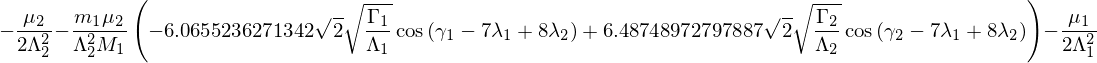

In [8]:
Hres

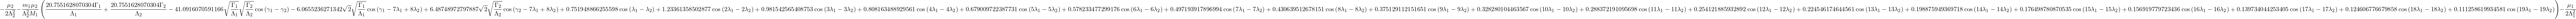

In [9]:
H

# Calculate Hamilton's equations symbolically

In [10]:
var = (m1, M1, mu1, mu2, lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2)
params = (m1, M1, mu1, mu2)

In [11]:
lambda1dot = lambdify(var, diff(H, Lambda1), 'numpy')
lambda2dot = lambdify(var, diff(H, Lambda2), 'numpy')
Lambda1dot = lambdify(var, -diff(H, lambda1), 'numpy')
Lambda2dot = lambdify(var, -diff(H, lambda2), 'numpy')
gamma1dot = lambdify(var, diff(H, Gamma1), 'numpy')
gamma2dot = lambdify(var, diff(H, Gamma2), 'numpy')
Gamma1dot = lambdify(var, -diff(H, gamma1), 'numpy')
Gamma2dot = lambdify(var, -diff(H, gamma2), 'numpy')
lambda1dotres = lambdify(var, diff(Hres, Lambda1), 'numpy')
lambda2dotres = lambdify(var, diff(Hres, Lambda2), 'numpy')
Lambda1dotres = lambdify(var, -diff(Hres, lambda1), 'numpy')
Lambda2dotres = lambdify(var, -diff(Hres, lambda2), 'numpy')
gamma1dotres = lambdify(var, diff(Hres, Gamma1), 'numpy')
gamma2dotres = lambdify(var, diff(Hres, Gamma2), 'numpy')
Gamma1dotres = lambdify(var, -diff(Hres, gamma1), 'numpy')
Gamma2dotres = lambdify(var, -diff(Hres, gamma2), 'numpy')
lambda1dotsec = lambdify(var, diff(Hsec, Lambda1), 'numpy')
lambda2dotsec = lambdify(var, diff(Hsec, Lambda2), 'numpy')
Lambda1dotsec = lambdify(var, -diff(Hsec, lambda1), 'numpy')
Lambda2dotsec = lambdify(var, -diff(Hsec, lambda2), 'numpy')
gamma1dotsec = lambdify(var, diff(Hsec, Gamma1), 'numpy')
gamma2dotsec = lambdify(var, diff(Hsec, Gamma2), 'numpy')
Gamma1dotsec = lambdify(var, -diff(Hsec, gamma1), 'numpy')
Gamma2dotsec = lambdify(var, -diff(Hsec, gamma2), 'numpy')
lambda1dotsyn = lambdify(var, diff(Hsyn, Lambda1), 'numpy')
lambda2dotsyn = lambdify(var, diff(Hsyn, Lambda2), 'numpy')
Lambda1dotsyn = lambdify(var, -diff(Hsyn, lambda1), 'numpy')
Lambda2dotsyn = lambdify(var, -diff(Hsyn, lambda2), 'numpy')
gamma1dotsyn = lambdify(var, diff(Hsyn, Gamma1), 'numpy')
gamma2dotsyn = lambdify(var, diff(Hsyn, Gamma2), 'numpy')
Gamma1dotsyn = lambdify(var, -diff(Hsyn, gamma1), 'numpy')
Gamma2dotsyn = lambdify(var, -diff(Hsyn, gamma2), 'numpy')

In [12]:
def diffeq(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dot(*var), lambda2dot(*var), Lambda1dot(*var), Lambda2dot(*var), gamma1dot(*var), gamma2dot(*var), Gamma1dot(*var), Gamma2dot(*var)]
    return dydt

def diffeqres(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dotres(*var), lambda2dotres(*var), Lambda1dotres(*var), Lambda2dotres(*var), gamma1dotres(*var), gamma2dotres(*var), Gamma1dotres(*var), Gamma2dotres(*var)]
    return dydt

def diffeqsec(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dotsec(*var), lambda2dotsec(*var), Lambda1dotsec(*var), Lambda2dotsec(*var), gamma1dotsec(*var), gamma2dotsec(*var), Gamma1dotsec(*var), Gamma2dotsec(*var)]
    return dydt

def diffeqsyn(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dotsyn(*var), lambda2dotsyn(*var), Lambda1dotsyn(*var), Lambda2dotsyn(*var), gamma1dotsyn(*var), gamma2dotsyn(*var), Gamma1dotsyn(*var), Gamma2dotsyn(*var)]
    return dydt

# Convenience functions for REBOUND Nbody integration

In [13]:
def mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return Mint*self.m/(Mint+self.m)

def Mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return (Mint+self.m)/Mint*self._sim.contents.particles[0].m

def Lambda(self):
    return self.mjac*np.sqrt(self._sim.contents.G*self.Mjac*self.a)

def Gamma(self):
    return self.Lambda*(1.-np.sqrt(1.-self.e**2))

def gamma(self):
    return -self.pomega

def J(self):
    if self.hash == 1:
        return self.Lambda + m*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    if self.hash == 2:
        return self.Lambda - (m+1)*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    
def mu(self):
    return self._sim.contents.G**2*self.Mjac**2*self.mjac**3

def phi(self):
    return (m+1)*self._sim.contents.particles[2].l - m*self._sim.contents.particles[1].l - self.pomega

rebound.Particle.mjac = property(mjac)
rebound.Particle.Mjac = property(Mjac)
rebound.Particle.Lambda = property(Lambda)
rebound.Particle.J = property(J)
rebound.Particle.mu = property(mu)
rebound.Particle.phi = property(phi)
rebound.Particle.Gamma = property(Gamma)
rebound.Particle.gamma = property(gamma)

def wrap(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

# Parameters for the integrations 

You can also mess around with these!

In [14]:
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 1000 # number of inner planet orbits to integrate for
Nout = 10000 # number of output points

# This function does an N-body integration and a numerical integration of Hamilton's equations we derived symbolically above

In [15]:
logmass = -5.1
delta = (1-alpha)/alpha*(2/3*10**logmass)**(-1/3)
print(10**logmass)
print(delta)

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m+1)/m)
sim.move_to_com()
ps = sim.particles

7.943282347242822e-06
5.341500186327213


In [16]:
deltan = 2*np.pi/ps[1].P-2*np.pi/ps[2].P
prefac = ps[2].mu/ps[2].Lambda**2*ps[1].m/ps[0].m/deltan

In [17]:
print(deltan)

0.7853981633974447


In [18]:
def transform(lambda1, lambda2, prefac):
    s=0
    for j in range(1,150):
        s += LaplaceCoefficient(0.5, j, alpha, 0)*np.cos(j*(lambda1-lambda2))
    s -= alpha*np.cos(lambda1-lambda2)
    s = s*prefac
    return s
nptransform = np.vectorize(transform)

In [29]:
s=0
deltalambda = 0.3
for j in range(1,150):
    s += LaplaceCoefficient(0.5, j, alpha, 0)*np.cos(j*deltalambda)
s -= alpha*np.cos(deltalambda)
s = s*prefac
print(s)

2.84973821521e-09


In [26]:
logmass = -5.1
delta = (1-alpha)/alpha*(2/3*10**logmass)**(-1/3)
print(10**logmass)
print(delta)

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m+1)/m)
sim.move_to_com()
ps = sim.particles

y0 = (ps[1].l, ps[2].l, ps[1].Lambda, ps[2].Lambda, ps[1].gamma, ps[2].gamma, ps[1].Gamma, ps[2].Gamma)
y0offset = (ps[1].l, ps[2].l, ps[1].Lambda-s, ps[2].Lambda+s, ps[1].gamma, ps[2].gamma, ps[1].Gamma, ps[2].Gamma)
params0 = (ps[1].m, ps[0].m, ps[1].mu, ps[2].mu)
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)

Nlambda1, Nlambda2, NLambda1, NLambda2, Ngamma1, Ngamma2, NGamma1, NGamma2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Nphi1, Nphi2, Nh1, Nk1, Nh2, Nk2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    orbits = sim.calculate_orbits(heliocentric=True)
    sim.integrate(time)
    Nlambda1[i] = orbits[0].l
    Nlambda2[i] = orbits[1].l
    NLambda1[i] = ps[1].m*np.sqrt(sim.G*ps[0].m*orbits[0].a)
    NLambda2[i] = ps[2].m*np.sqrt(sim.G*ps[0].m*orbits[1].a)
    Ngamma1[i] = -orbits[0].pomega
    Ngamma2[i] = -orbits[1].pomega
    NGamma1[i] = NLambda1[i]*(1.-np.sqrt(1.-orbits[0].e**2))
    NGamma2[i] = NLambda2[i]*(1.-np.sqrt(1.-orbits[1].e**2))
    Nphi1[i] = ps[1].phi
    Nphi2[i] = ps[2].phi
    Nh1[i] = ps[1].e*np.cos(Nphi1[i])
    Nk1[i] = ps[1].e*np.sin(Nphi1[i])
    Nh2[i] = ps[2].e*np.cos(Nphi2[i])
    Nk2[i] = ps[2].e*np.sin(Nphi2[i])

Nlambda1=npwrap(Nlambda1)
Nlambda2=npwrap(Nlambda2)
Ngamma1=npwrap(Ngamma1)
Ngamma2=npwrap(Ngamma2)
Nphi1 = npwrap(Nphi1)
Nphi2 = npwrap(Nphi2)

sol = odeint(diffeq, y0, times, args=params0)
Hlambda1 = npwrap(sol[:,0])
Hlambda2 = npwrap(sol[:,1])
HLambda1 = sol[:,2]
HLambda2 = sol[:,3]
Hgamma1 = npwrap(sol[:,4])
Hgamma2 = npwrap(sol[:,5])
HGamma1 = sol[:,6]
HGamma2 = sol[:,7]
Hphi1 = npwrap((m+1)*Hlambda2 - m*Hlambda1 + Hgamma1)
Hphi2 = npwrap((m+1)*Hlambda2 - m*Hlambda1 + Hgamma2)
Hh1 = np.sqrt(2.*HGamma1/HLambda1)*np.cos(Hphi1)
Hk1 = np.sqrt(2.*HGamma1/HLambda1)*np.sin(Hphi1)
Hh2 = np.sqrt(2.*HGamma2/HLambda2)*np.cos(Hphi2)
Hk2 = np.sqrt(2.*HGamma2/HLambda2)*np.sin(Hphi2)

solres = odeint(diffeqres, y0offset, times, args=params0)
Hlambda1res = npwrap(solres[:,0])
Hlambda2res = npwrap(solres[:,1])
HLambda1res = solres[:,2]
HLambda2res = solres[:,3]
Hgamma1res = npwrap(solres[:,4])
Hgamma2res = npwrap(solres[:,5])
HGamma1res = solres[:,6]
HGamma2res = solres[:,7]
Hphi1res = npwrap((m+1)*Hlambda2res - m*Hlambda1res + Hgamma1res)
Hphi2res = npwrap((m+1)*Hlambda2res - m*Hlambda1res + Hgamma2res)
Hh1res = np.sqrt(2.*HGamma1res/HLambda1res)*np.cos(Hphi1res)
Hk1res = np.sqrt(2.*HGamma1res/HLambda1res)*np.sin(Hphi1res)
Hh2res = np.sqrt(2.*HGamma2res/HLambda2res)*np.cos(Hphi2res)
Hk2res = np.sqrt(2.*HGamma2res/HLambda2res)*np.sin(Hphi2res)

solsec = odeint(diffeqsec, y0, times, args=params0)
Hlambda1sec = npwrap(solsec[:,0])
Hlambda2sec = npwrap(solsec[:,1])
HLambda1sec = solsec[:,2]
HLambda2sec = solsec[:,3]
Hgamma1sec = npwrap(solsec[:,4])
Hgamma2sec = npwrap(solsec[:,5])
HGamma1sec = solsec[:,6]
HGamma2sec = solsec[:,7]
Hphi1sec = npwrap((m+1)*Hlambda2sec - m*Hlambda1sec + Hgamma1sec)
Hphi2sec = npwrap((m+1)*Hlambda2sec - m*Hlambda1sec + Hgamma2sec)
Hh1sec = np.sqrt(2.*HGamma1sec/HLambda1sec)*np.cos(Hphi1sec)
Hk1sec = np.sqrt(2.*HGamma1sec/HLambda1sec)*np.sin(Hphi1sec)
Hh2sec = np.sqrt(2.*HGamma2sec/HLambda2sec)*np.cos(Hphi2sec)
Hk2sec = np.sqrt(2.*HGamma2sec/HLambda2sec)*np.sin(Hphi2sec)

solsyn = odeint(diffeqsyn, y0, times, args=params0)
Hlambda1syn = npwrap(solsyn[:,0])
Hlambda2syn = npwrap(solsyn[:,1])
HLambda1syn = solsyn[:,2]
HLambda2syn = solsyn[:,3]
Hgamma1syn = npwrap(solsyn[:,4])
Hgamma2syn = npwrap(solsyn[:,5])
HGamma1syn = solsyn[:,6]
HGamma2syn = solsyn[:,7]
Hphi1syn = npwrap((m+1)*Hlambda2syn - m*Hlambda1syn + Hgamma1syn)
Hphi2syn = npwrap((m+1)*Hlambda2syn - m*Hlambda1syn + Hgamma2syn)
Hh1syn = np.sqrt(2.*HGamma1syn/HLambda1syn)*np.cos(Hphi1syn)
Hk1syn = np.sqrt(2.*HGamma1syn/HLambda1syn)*np.sin(Hphi1syn)
Hh2syn = np.sqrt(2.*HGamma2syn/HLambda2syn)*np.cos(Hphi2syn)
Hk2syn = np.sqrt(2.*HGamma2syn/HLambda2syn)*np.sin(Hphi2syn)

7.943282347242822e-06
5.341500186327213


In [29]:
#HLambda1Trans = HLambda1res+nptransform(Hlambda1res, Hlambda2res, prefac)

KeyboardInterrupt: 

In [28]:
#HGamma1Trans = HGamma1res/HLambda1res*HLambda1Trans

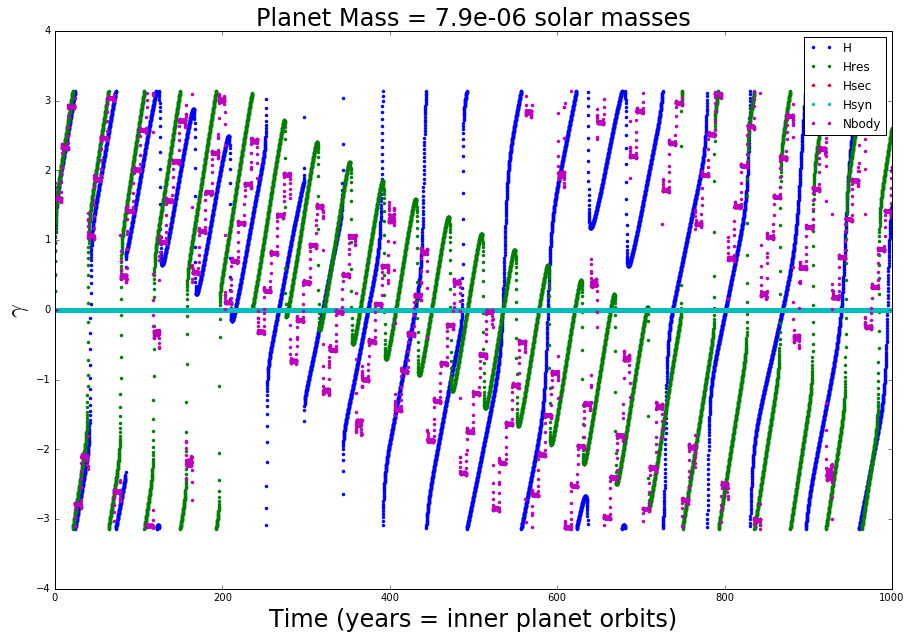

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\gamma$", fontsize=24)

ax.plot(times, Hgamma1, '.', label='H')
ax.plot(times, Hgamma1res, '.', label='Hres')
ax.plot(times, Hgamma1sec, '.', label='Hsec')
ax.plot(times, Hgamma1syn, '.', label='Hsyn')
ax.plot(times, Ngamma1, '.', label='Nbody')

ax.legend()

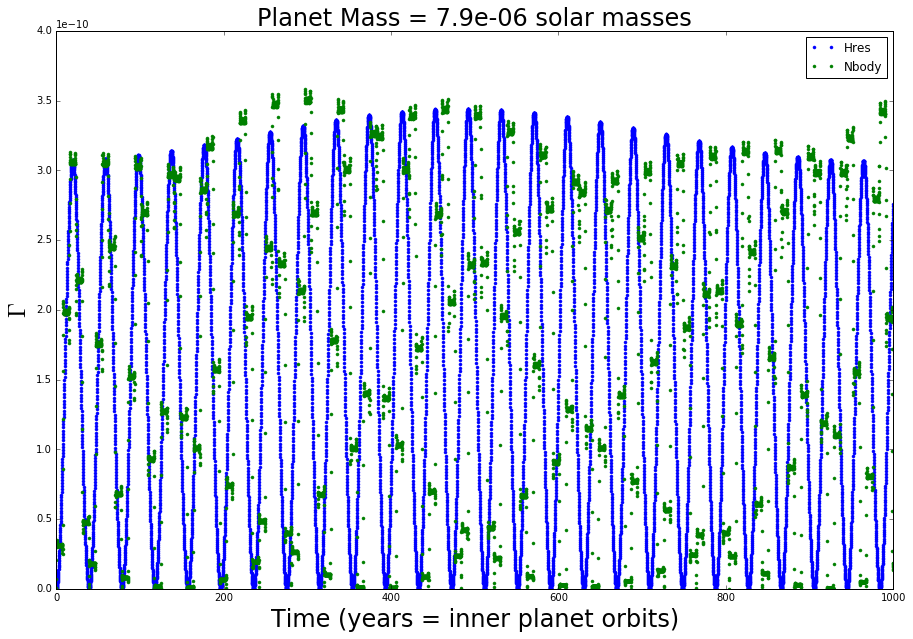

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Gamma$", fontsize=24)

#ax.plot(times, HGamma1, '.', label='H')
ax.plot(times, HGamma1res, '.', label='Hres')
#ax.plot(times, HGamma1sec, '.', label='Hsec')
#ax.plot(times, HGamma1syn, '.', label='Hsyn')
ax.plot(times, NGamma1, '.', label='Nbody')

ax.legend()

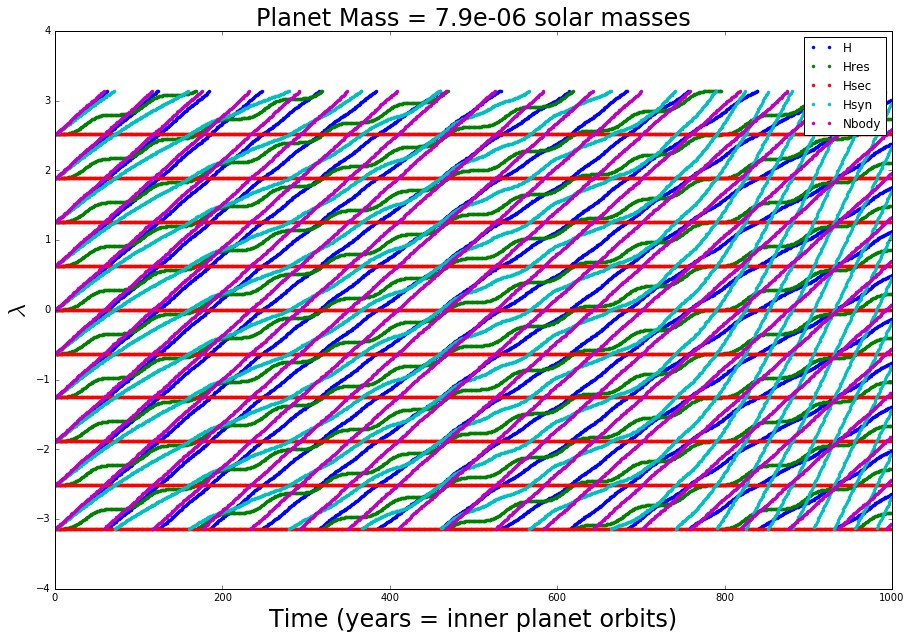

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\lambda$", fontsize=24)

ax.plot(times, Hlambda1, '.', label='H')
ax.plot(times, Hlambda1res, '.', label='Hres')
ax.plot(times, Hlambda1sec, '.', label='Hsec')
ax.plot(times, Hlambda1syn, '.', label='Hsyn')
ax.plot(times, Nlambda1, '.', label='Nbody')

ax.legend()

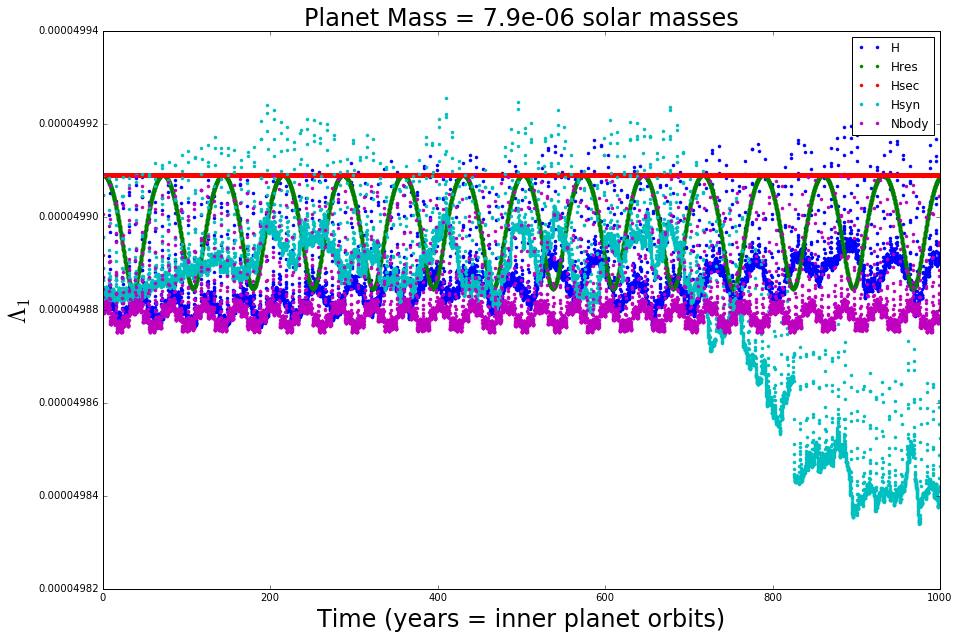

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Lambda_1$", fontsize=24)

ax.plot(times, HLambda1, '.', label='H')
ax.plot(times, HLambda1res, '.', label='Hres')
ax.plot(times, HLambda1sec, '.', label='Hsec')
ax.plot(times, HLambda1syn, '.', label='Hsyn')
ax.plot(times, NLambda1, '.', label='Nbody')

ax.legend()

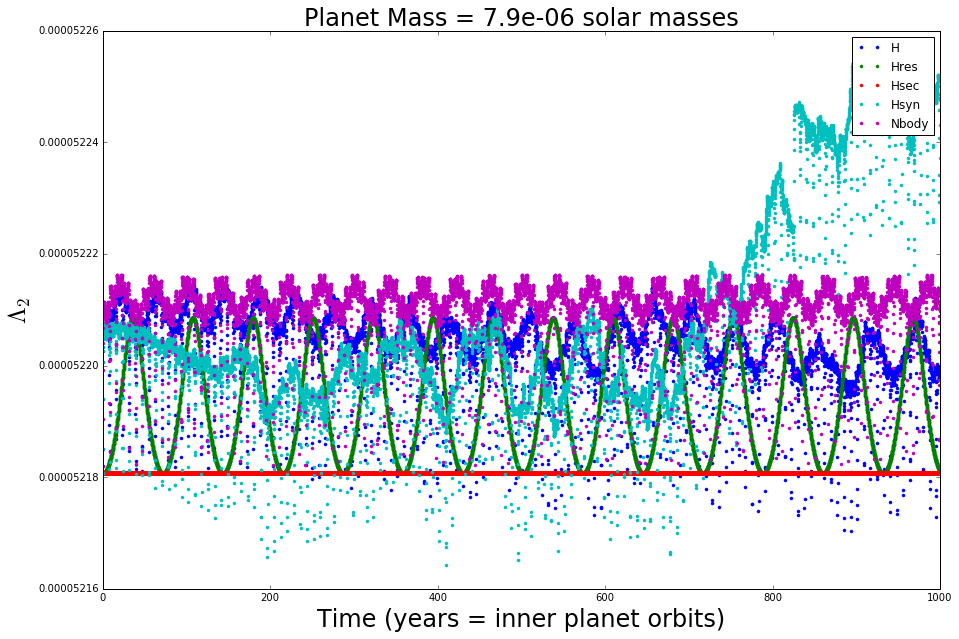

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Lambda_2$", fontsize=24)

ax.plot(times, HLambda2, '.', label='H')
ax.plot(times, HLambda2res, '.', label='Hres')
ax.plot(times, HLambda2sec, '.', label='Hsec')
ax.plot(times, HLambda2syn, '.', label='Hsyn')
ax.plot(times, NLambda2, '.', label='Nbody')

ax.legend()

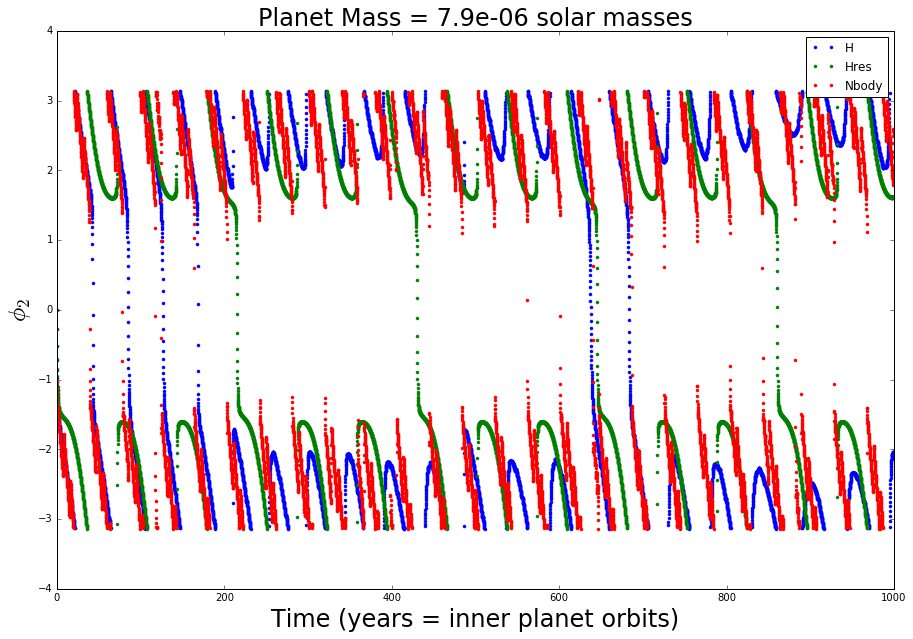

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\phi_2$", fontsize=24)

ax.plot(times, Hphi2, '.', label='H')
ax.plot(times, Hphi2res, '.', label='Hres')
#ax.plot(times, Hphi1sec, '.', label='Hsec')
#ax.plot(times, Hphi1syn, '.', label='Hsyn')
ax.plot(times, Nphi2, '.', label='Nbody')

ax.legend()

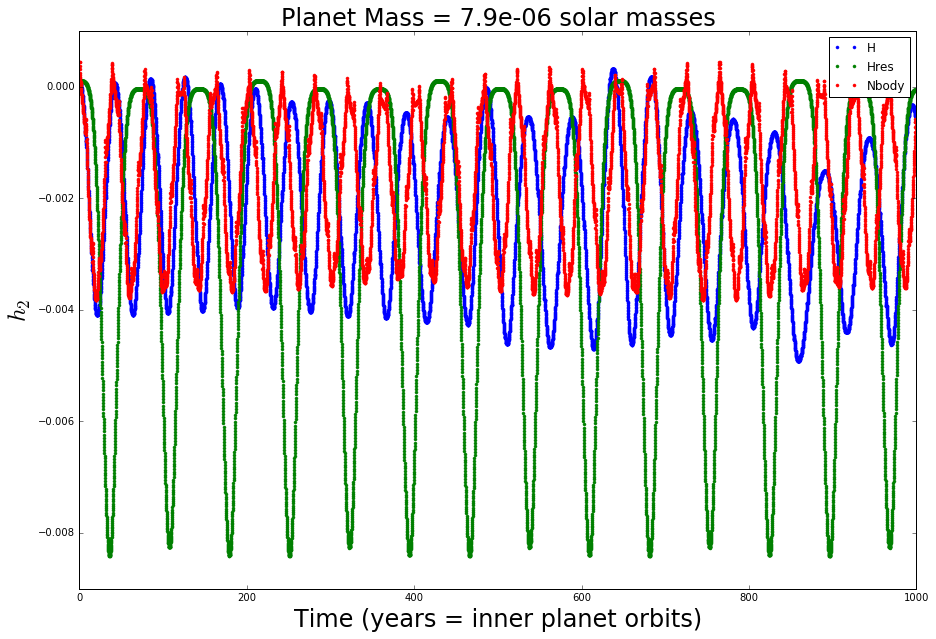

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$h_2$", fontsize=24)

ax.plot(times, Hh2, '.', label='H')
ax.plot(times, Hh2res, '.', label='Hres')
#ax.plot(times, Hh2sec, '.', label='Hsec')
#ax.plot(times, Hh2syn, '.', label='Hsyn')
ax.plot(times, Nh2, '.', label='Nbody')

ax.legend()

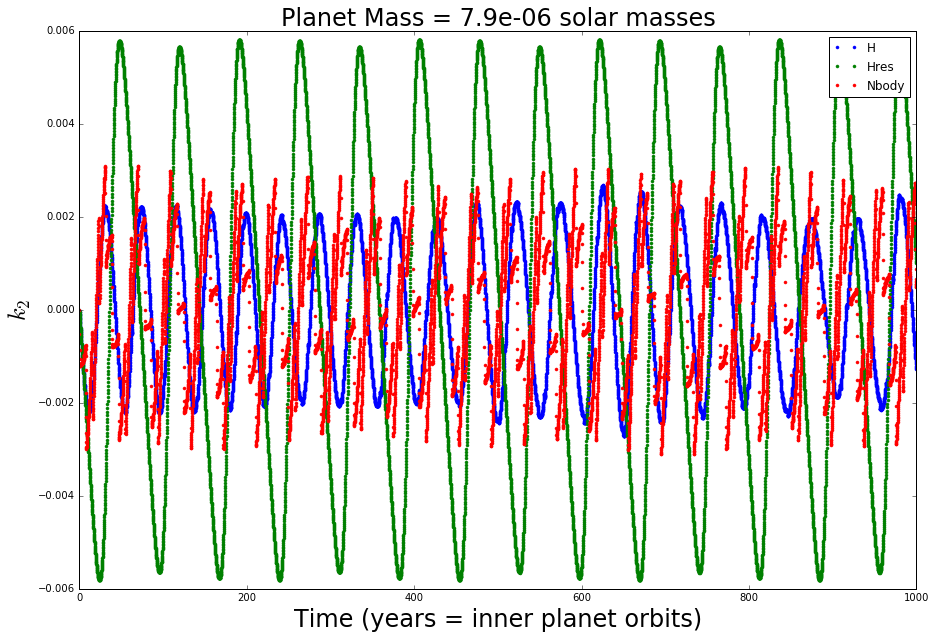

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$k_2$", fontsize=24)

ax.plot(times, Hk2, '.', label='H')
ax.plot(times, Hk2res, '.', label='Hres')
#ax.plot(times, Hk2sec, '.', label='Hsec')
#ax.plot(times, Hk2syn, '.', label='Hsyn')
ax.plot(times, Nk2, '.', label='Nbody')

ax.legend()

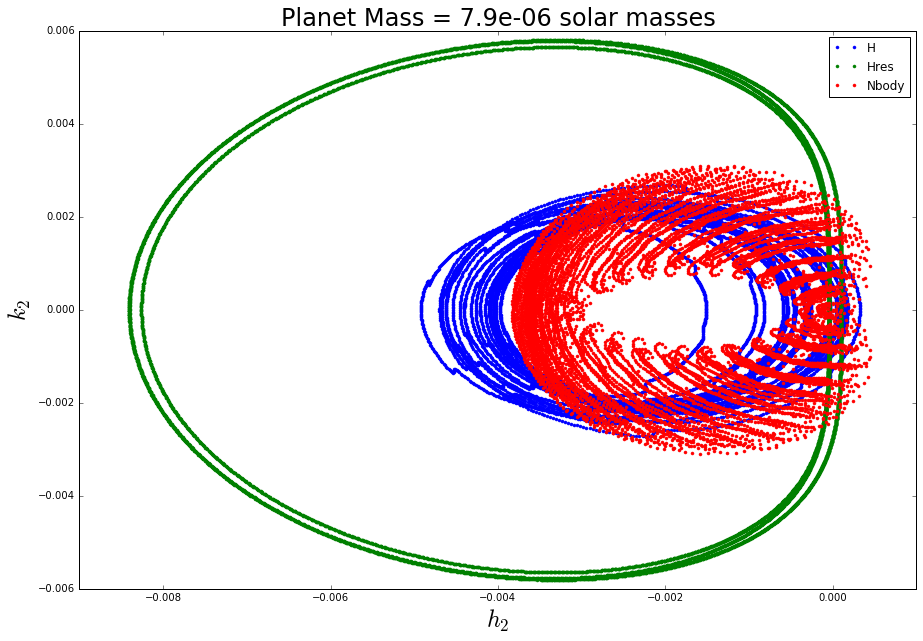

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("$h_2$", fontsize=24)
ax.set_ylabel(r"$k_2$", fontsize=24)

ax.plot(Hh2, Hk2, '.', label='H')
ax.plot(Hh2res, Hk2res, '.', label='Hres')
#ax.plot(times, Hphi1sec, '.', label='Hsec')
#ax.plot(times, Hphi1syn, '.', label='Hsyn')
ax.plot(Nh2, Nk2, '.', label='Nbody')

ax.legend()

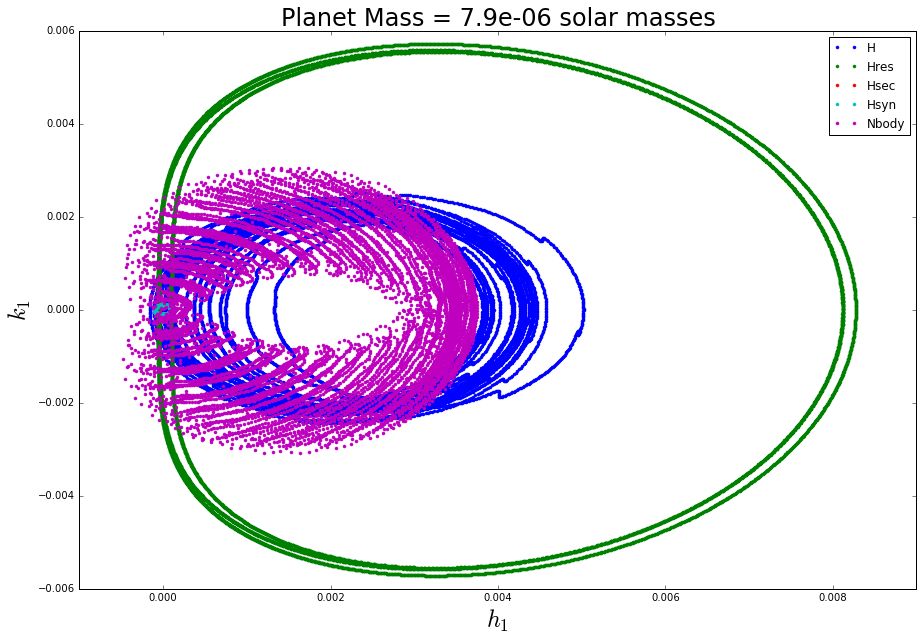

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("$h_1$", fontsize=24)
ax.set_ylabel(r"$k_1$", fontsize=24)

ax.plot(Hh1, Hk1, '.', label='H')
ax.plot(Hh1res, Hk1res, '.', label='Hres')
ax.plot(Hh1sec, Hk1sec, '.', label='Hsec')
ax.plot(Hh1syn, Hk1syn, '.', label='Hsyn')
ax.plot(Nh1, Nk1, '.', label='Nbody')

ax.legend()

In [27]:
mass = 10**logmass
L1 = 4.988e-5
L2 = 5.221e-5
a1 = L1**2/(4*np.pi**2*mass**2)
a2 = L2**2/(4*np.pi**2*mass**2)
oldalpha = alpha
alpha = a1/a2
print(oldalpha, alpha, (oldalpha-alpha)/oldalpha)

0.9148264275057428 0.9127366787164574 0.0022843117846771586


In [28]:
jmax=20
Tsyn = 0
for j in range(1, jmax):
    Tsyn += LaplaceCoefficient(0.5, j, alpha, 0)*cos(j*(lambda1-lambda2))
Tsyn -= alpha*cos(lambda1-lambda2)

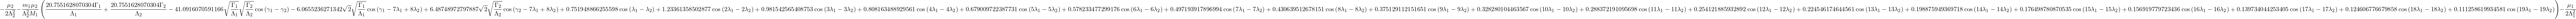

In [30]:
Hold = H
Hold

In [31]:
Tf27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))*sqrt(2*Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1)
Tf31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2)
Tfs1 = 1/8*(2*alpha*LaplaceCoefficient(0.5, 0, alpha, 1) + alpha**2*LaplaceCoefficient(0.5, 0, alpha, 2))*2*(Gamma1/Lambda1 + Gamma2/Lambda2)
Tfs2 = 1/4*(2-2*alpha*LaplaceCoefficient(0.5, 1, alpha, 1) - alpha**2*LaplaceCoefficient(0.5, 1, alpha, 2))*2*sqrt(Gamma1/Lambda1)*sqrt(Gamma2/Lambda2)*cos(gamma1-gamma2)
H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
Hres = H0 - m1/M1*mu2/Lambda2**2*(Tf27 + Tf31)
Hsec = H0 - m1/M1*mu2/Lambda2**2*(Tfs1 + Tfs2)
Hsyn = H0 - m1/M1*mu2/Lambda2**2*(Tsyn)
H = H0 - m1/M1*mu2/Lambda2**2*(Tf27 + Tf31 + Tfs1 + Tfs2 + Tsyn)

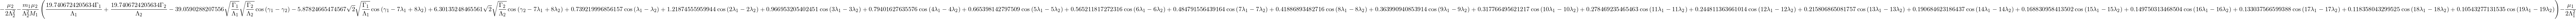

In [32]:
H

In [34]:
var = (m1, M1, mu1, mu2, lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2)
params = (m1, M1, mu1, mu2)
lambda1dot = lambdify(var, diff(H, Lambda1), 'numpy')
lambda2dot = lambdify(var, diff(H, Lambda2), 'numpy')
Lambda1dot = lambdify(var, -diff(H, lambda1), 'numpy')
Lambda2dot = lambdify(var, -diff(H, lambda2), 'numpy')
gamma1dot = lambdify(var, diff(H, Gamma1), 'numpy')
gamma2dot = lambdify(var, diff(H, Gamma2), 'numpy')
Gamma1dot = lambdify(var, -diff(H, gamma1), 'numpy')
Gamma2dot = lambdify(var, -diff(H, gamma2), 'numpy')
lambda1dotres = lambdify(var, diff(Hres, Lambda1), 'numpy')
lambda2dotres = lambdify(var, diff(Hres, Lambda2), 'numpy')
Lambda1dotres = lambdify(var, -diff(Hres, lambda1), 'numpy')
Lambda2dotres = lambdify(var, -diff(Hres, lambda2), 'numpy')
gamma1dotres = lambdify(var, diff(Hres, Gamma1), 'numpy')
gamma2dotres = lambdify(var, diff(Hres, Gamma2), 'numpy')
Gamma1dotres = lambdify(var, -diff(Hres, gamma1), 'numpy')
Gamma2dotres = lambdify(var, -diff(Hres, gamma2), 'numpy')
lambda1dotsec = lambdify(var, diff(Hsec, Lambda1), 'numpy')
lambda2dotsec = lambdify(var, diff(Hsec, Lambda2), 'numpy')
Lambda1dotsec = lambdify(var, -diff(Hsec, lambda1), 'numpy')
Lambda2dotsec = lambdify(var, -diff(Hsec, lambda2), 'numpy')
gamma1dotsec = lambdify(var, diff(Hsec, Gamma1), 'numpy')
gamma2dotsec = lambdify(var, diff(Hsec, Gamma2), 'numpy')
Gamma1dotsec = lambdify(var, -diff(Hsec, gamma1), 'numpy')
Gamma2dotsec = lambdify(var, -diff(Hsec, gamma2), 'numpy')
lambda1dotsyn = lambdify(var, diff(Hsyn, Lambda1), 'numpy')
lambda2dotsyn = lambdify(var, diff(Hsyn, Lambda2), 'numpy')
Lambda1dotsyn = lambdify(var, -diff(Hsyn, lambda1), 'numpy')
Lambda2dotsyn = lambdify(var, -diff(Hsyn, lambda2), 'numpy')
gamma1dotsyn = lambdify(var, diff(Hsyn, Gamma1), 'numpy')
gamma2dotsyn = lambdify(var, diff(Hsyn, Gamma2), 'numpy')
Gamma1dotsyn = lambdify(var, -diff(Hsyn, gamma1), 'numpy')
Gamma2dotsyn = lambdify(var, -diff(Hsyn, gamma2), 'numpy')
def diffeq(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dot(*var), lambda2dot(*var), Lambda1dot(*var), Lambda2dot(*var), gamma1dot(*var), gamma2dot(*var), Gamma1dot(*var), Gamma2dot(*var)]
    return dydt

def diffeqres(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dotres(*var), lambda2dotres(*var), Lambda1dotres(*var), Lambda2dotres(*var), gamma1dotres(*var), gamma2dotres(*var), Gamma1dotres(*var), Gamma2dotres(*var)]
    return dydt

def diffeqsec(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dotsec(*var), lambda2dotsec(*var), Lambda1dotsec(*var), Lambda2dotsec(*var), gamma1dotsec(*var), gamma2dotsec(*var), Gamma1dotsec(*var), Gamma2dotsec(*var)]
    return dydt

def diffeqsyn(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dotsyn(*var), lambda2dotsyn(*var), Lambda1dotsyn(*var), Lambda2dotsyn(*var), gamma1dotsyn(*var), gamma2dotsyn(*var), Gamma1dotsyn(*var), Gamma2dotsyn(*var)]
    return dydt

In [35]:
logmass = -5.1
delta = (1-alpha)/alpha*(2/3*10**logmass)**(-1/3)
print(10**logmass)
print(delta)

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, a=a1)
sim.add(m=10**logmass, e=e0, a=a2)
sim.move_to_com()
ps = sim.particles

y0 = (ps[1].l, ps[2].l, ps[1].Lambda, ps[2].Lambda, ps[1].gamma, ps[2].gamma, ps[1].Gamma, ps[2].Gamma)
params0 = (ps[1].m, ps[0].m, ps[1].mu, ps[2].mu)
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)

Nlambda1, Nlambda2, NLambda1, NLambda2, Ngamma1, Ngamma2, NGamma1, NGamma2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Nphi1, Nphi2, Nh1, Nk1, Nh2, Nk2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    orbits = sim.calculate_orbits(heliocentric=True)
    sim.integrate(time)
    Nlambda1[i] = orbits[0].l
    Nlambda2[i] = orbits[1].l
    NLambda1[i] = ps[1].m*np.sqrt(sim.G*ps[0].m*orbits[0].a)
    NLambda2[i] = ps[2].m*np.sqrt(sim.G*ps[0].m*orbits[1].a)
    Ngamma1[i] = -orbits[0].pomega
    Ngamma2[i] = -orbits[1].pomega
    NGamma1[i] = NLambda1[i]*(1.-np.sqrt(1.-orbits[0].e**2))
    NGamma2[i] = NLambda2[i]*(1.-np.sqrt(1.-orbits[1].e**2))
    Nphi1[i] = ps[1].phi
    Nphi2[i] = ps[2].phi
    Nh1[i] = ps[1].e*np.cos(Nphi1[i])
    Nk1[i] = ps[1].e*np.sin(Nphi1[i])
    Nh2[i] = ps[2].e*np.cos(Nphi2[i])
    Nk2[i] = ps[2].e*np.sin(Nphi2[i])

Nlambda1=npwrap(Nlambda1)
Nlambda2=npwrap(Nlambda2)
Ngamma1=npwrap(Ngamma1)
Ngamma2=npwrap(Ngamma2)
Nphi1 = npwrap(Nphi1)
Nphi2 = npwrap(Nphi2)

sol = odeint(diffeq, y0, times, args=params0)
Hlambda1 = npwrap(sol[:,0])
Hlambda2 = npwrap(sol[:,1])
HLambda1 = sol[:,2]
HLambda2 = sol[:,3]
Hgamma1 = npwrap(sol[:,4])
Hgamma2 = npwrap(sol[:,5])
HGamma1 = sol[:,6]
HGamma2 = sol[:,7]
Hphi1 = npwrap((m+1)*Hlambda2 - m*Hlambda1 + Hgamma1)
Hphi2 = npwrap((m+1)*Hlambda2 - m*Hlambda1 + Hgamma2)
Hh1 = np.sqrt(2.*HGamma1/HLambda1)*np.cos(Hphi1)
Hk1 = np.sqrt(2.*HGamma1/HLambda1)*np.sin(Hphi1)
Hh2 = np.sqrt(2.*HGamma2/HLambda2)*np.cos(Hphi2)
Hk2 = np.sqrt(2.*HGamma2/HLambda2)*np.sin(Hphi2)

solres = odeint(diffeqres, y0, times, args=params0)
Hlambda1res = npwrap(solres[:,0])
Hlambda2res = npwrap(solres[:,1])
HLambda1res = solres[:,2]
HLambda2res = solres[:,3]
Hgamma1res = npwrap(solres[:,4])
Hgamma2res = npwrap(solres[:,5])
HGamma1res = solres[:,6]
HGamma2res = solres[:,7]
Hphi1res = npwrap((m+1)*Hlambda2res - m*Hlambda1res + Hgamma1res)
Hphi2res = npwrap((m+1)*Hlambda2res - m*Hlambda1res + Hgamma2res)
Hh1res = np.sqrt(2.*HGamma1res/HLambda1res)*np.cos(Hphi1res)
Hk1res = np.sqrt(2.*HGamma1res/HLambda1res)*np.sin(Hphi1res)
Hh2res = np.sqrt(2.*HGamma2res/HLambda2res)*np.cos(Hphi2res)
Hk2res = np.sqrt(2.*HGamma2res/HLambda2res)*np.sin(Hphi2res)

solsec = odeint(diffeqsec, y0, times, args=params0)
Hlambda1sec = npwrap(solsec[:,0])
Hlambda2sec = npwrap(solsec[:,1])
HLambda1sec = solsec[:,2]
HLambda2sec = solsec[:,3]
Hgamma1sec = npwrap(solsec[:,4])
Hgamma2sec = npwrap(solsec[:,5])
HGamma1sec = solsec[:,6]
HGamma2sec = solsec[:,7]
Hphi1sec = npwrap((m+1)*Hlambda2sec - m*Hlambda1sec + Hgamma1sec)
Hphi2sec = npwrap((m+1)*Hlambda2sec - m*Hlambda1sec + Hgamma2sec)
Hh1sec = np.sqrt(2.*HGamma1sec/HLambda1sec)*np.cos(Hphi1sec)
Hk1sec = np.sqrt(2.*HGamma1sec/HLambda1sec)*np.sin(Hphi1sec)
Hh2sec = np.sqrt(2.*HGamma2sec/HLambda2sec)*np.cos(Hphi2sec)
Hk2sec = np.sqrt(2.*HGamma2sec/HLambda2sec)*np.sin(Hphi2sec)

solsyn = odeint(diffeqsyn, y0, times, args=params0)
Hlambda1syn = npwrap(solsyn[:,0])
Hlambda2syn = npwrap(solsyn[:,1])
HLambda1syn = solsyn[:,2]
HLambda2syn = solsyn[:,3]
Hgamma1syn = npwrap(solsyn[:,4])
Hgamma2syn = npwrap(solsyn[:,5])
HGamma1syn = solsyn[:,6]
HGamma2syn = solsyn[:,7]
Hphi1syn = npwrap((m+1)*Hlambda2syn - m*Hlambda1syn + Hgamma1syn)
Hphi2syn = npwrap((m+1)*Hlambda2syn - m*Hlambda1syn + Hgamma2syn)
Hh1syn = np.sqrt(2.*HGamma1syn/HLambda1syn)*np.cos(Hphi1syn)
Hk1syn = np.sqrt(2.*HGamma1syn/HLambda1syn)*np.sin(Hphi1syn)
Hh2syn = np.sqrt(2.*HGamma2syn/HLambda2syn)*np.cos(Hphi2syn)
Hk2syn = np.sqrt(2.*HGamma2syn/HLambda2syn)*np.sin(Hphi2syn)

7.943282347242822e-06
5.4850844890325225


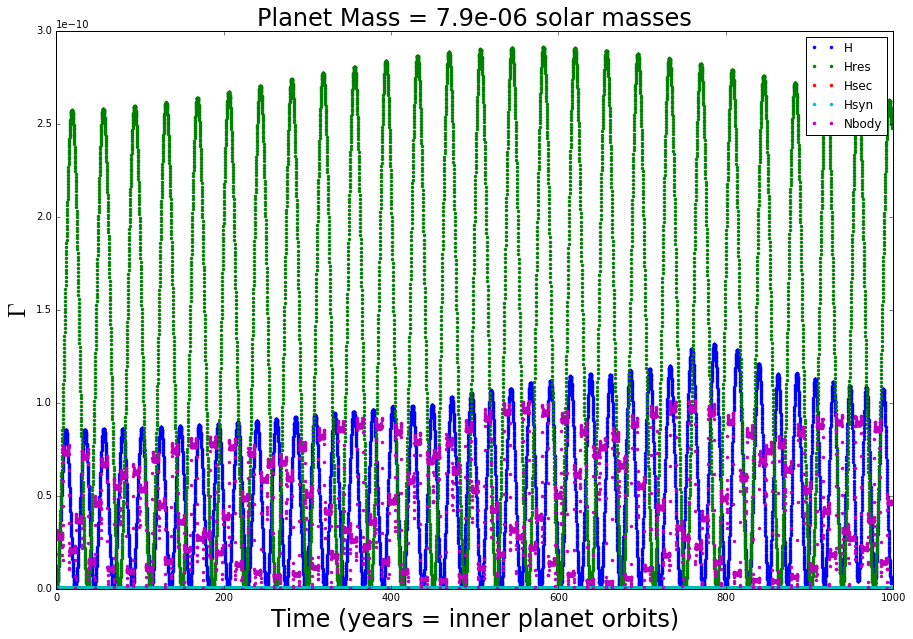

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Gamma$", fontsize=24)

ax.plot(times, HGamma1, '.', label='H')
ax.plot(times, HGamma1res, '.', label='Hres')
ax.plot(times, HGamma1sec, '.', label='Hsec')
ax.plot(times, HGamma1syn, '.', label='Hsyn')
ax.plot(times, NGamma1, '.', label='Nbody')

ax.legend()

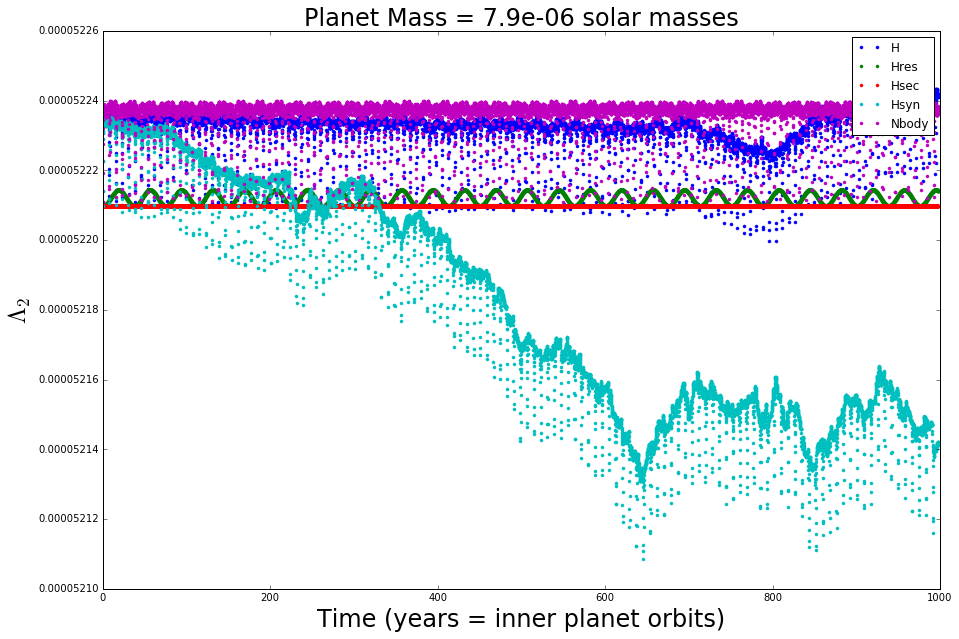

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Lambda_2$", fontsize=24)

ax.plot(times, HLambda2, '.', label='H')
ax.plot(times, HLambda2res, '.', label='Hres')
ax.plot(times, HLambda2sec, '.', label='Hsec')
ax.plot(times, HLambda2syn, '.', label='Hsyn')
ax.plot(times, NLambda2, '.', label='Nbody')

ax.legend()

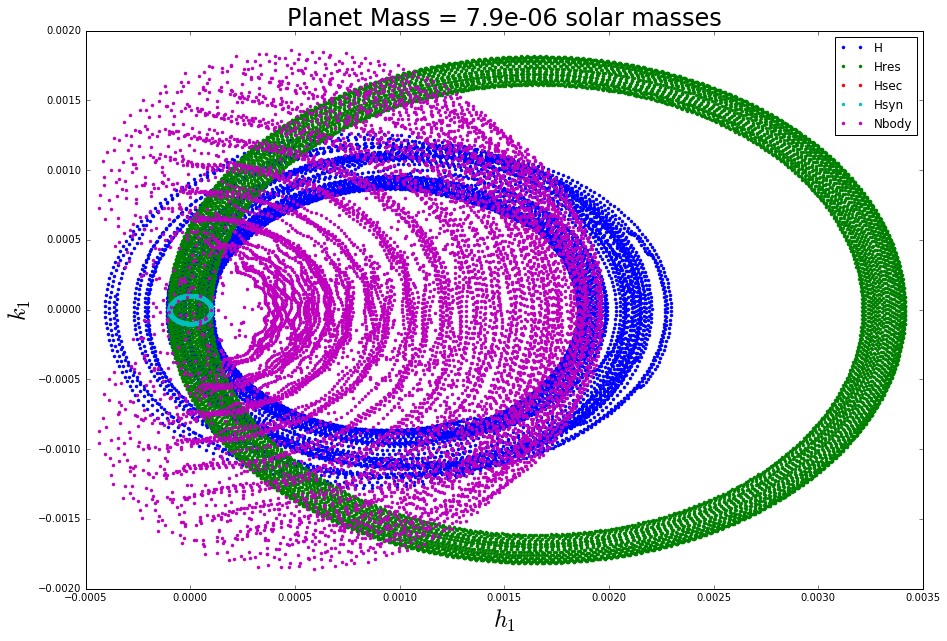

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("$h_1$", fontsize=24)
ax.set_ylabel(r"$k_1$", fontsize=24)

ax.plot(Hh1, Hk1, '.', label='H')
ax.plot(Hh1res, Hk1res, '.', label='Hres')
ax.plot(Hh1sec, Hk1sec, '.', label='Hsec')
ax.plot(Hh1syn, Hk1syn, '.', label='Hsyn')
ax.plot(Nh1, Nk1, '.', label='Nbody')

ax.legend()